In [1]:
from google.colab import files
uploaded = files.upload()

Saving Air_Quality_and_Pollen_Count.csv to Air_Quality_and_Pollen_Count.csv


In [3]:
import pandas as pd
import numpy as np

df=pd.read_csv('Air_Quality_and_Pollen_Count.csv')

df.head()

,OBJECTID,AQI,Category,ResponsiblePollutant,PollenCount,PollenType,PollenDescription,ReportDateTime
0,1,47.0,Good,PM2.5,9.0,Juniper,Maple,2025/04/04 05:00:00+00
1,2,49.0,Good,PM2.5,1.0,Elm,Juniper,2025/04/03 05:00:00+00
2,3,51.0,Moderate,PM2.5,11.0,Elm,Juniper,2025/04/02 05:00:00+00
3,4,50.0,Good,PM2.5,10.0,Elm,Juniper,2025/04/01 05:00:00+00
4,5,50.0,Good,PM2.5,2.0,Elm,Juniper,2025/03/31 05:00:00+00


## Step 1: Time-Based Feature Engineering
> ✔ Converted ReportDateTime column to proper datetime format
>
>
> ✔ Removed timezone artifacts for consistency
>
> ✔ Created new columns:
>
> - `Date` – extracted date only
> - `Week` – ISO week number for trend grouping
> - `Month` – numeric month for seasonal grouping
> - `DayOfWeek` – day name for weekday/weekend analysis

This step sets the foundation for identifying **temporal trends** in AQI and pollen exposure.

In [4]:
# Convert datetime column and drop timezone
df['ReportDateTime'] = pd.to_datetime(df['ReportDateTime']).dt.tz_localize(None)

# Create new time features
df['Date'] = df['ReportDateTime'].dt.date
df['Week'] = df['ReportDateTime'].dt.isocalendar().week
df['Month'] = df['ReportDateTime'].dt.month
df['DayOfWeek'] = df['ReportDateTime'].dt.day_name()

# Preview changes
df[['ReportDateTime', 'Date', 'Week', 'Month', 'DayOfWeek']].head()


,ReportDateTime,Date,Week,Month,DayOfWeek
0,2025-04-04 05:00:00,2025-04-04,14,4,Friday
1,2025-04-03 05:00:00,2025-04-03,14,4,Thursday
2,2025-04-02 05:00:00,2025-04-02,14,4,Wednesday
3,2025-04-01 05:00:00,2025-04-01,14,4,Tuesday
4,2025-03-31 05:00:00,2025-03-31,14,3,Monday


# Step 2: Handle Missing Data
### Missing Value Treatment

- AQI had ~2.5% missing data → dropped those rows
- ResponsiblePollutant filled with most frequent value
- PollenType and PollenDescription filled with 'Unknown'
- PollenCount filled with 0 (assumed no activity)

This preserves as much data as possible while minimizing noise from missing values.


In [5]:
# Fill pollutant with most common value
df['ResponsiblePollutant'].fillna(df['ResponsiblePollutant'].mode()[0], inplace=True)

# Fill PollenType and Description with 'Unknown'
df['PollenType'].fillna('Unknown', inplace=True)
df['PollenDescription'].fillna('Unknown', inplace=True)

# Fill PollenCount with 0 (assume no pollen activity if blank)
df['PollenCount'].fillna(0, inplace=True)

# Drop remaining rows with missing AQI (small amount)
df.dropna(subset=['AQI'], inplace=True)

<ipython-input-5-1069544369>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ResponsiblePollutant'].fillna(df['ResponsiblePollutant'].mode()[0], inplace=True)
<ipython-input-5-1069544369>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(

### Step 2.1 Post-Cleaning Validation

After handling missing data, I ran a quick check to confirm the dataset is clean and ready for transformation and analysis.

- **Missing values check:** No null values remain across key columns
- **Final dataset shape:** `(XXXX, 13)` ← Update with your actual row/column count

This confirms the dataset is now consistent, complete, and analysis-ready.


In [6]:
# Check for any remaining missing values
print(df.isnull().sum())

# Check final dataset shape
print("Final row count and columns:", df.shape)

OBJECTID                0
AQI                     0
Category                0
ResponsiblePollutant    0
PollenCount             0
PollenType              0
PollenDescription       0
ReportDateTime          0
Date                    0
Week                    0
Month                   0
DayOfWeek               0
dtype: int64
Final row count and columns: (8692, 12)


### Step 3: Severity Feature Engineering

To simplify analysis and create more readable insights, I transformed raw AQI and PollenCount values into severity categories:

- **AQI → AQI_Level** using US EPA standards
- **PollenCount → Pollen_Level** using common pollen risk thresholds

These categories make trend analysis and visual summaries more intuitive and presentation-ready.


In [9]:
# Define function to categorize AQI based on US EPA standards

def categorize_aqi(aqi):
    if aqi <= 50:
        return 'Good'
    elif aqi <= 100:
        return 'Moderate'
    elif aqi <= 150:
        return 'Unhealthy (Sensitive)'
    elif aqi <= 200:
        return 'Unhealthy'
    elif aqi <= 300:
        return 'Very Unhealthy'
    else:
        return 'Hazardous'

df['AQI_Level'] = df['AQI'].apply(categorize_aqi)

In [10]:
# Define function to categorize PollenCount into risk levels

def categorize_pollen(count):
    if count <= 5:
        return 'Low'
    elif count <= 15:
        return 'Moderate'
    elif count <= 30:
        return 'High'
    else:
        return 'Very High'

df['Pollen_Level'] = df['PollenCount'].apply(categorize_pollen)


## Visualizing AQI and Pollen Trends

These plots help uncover seasonal and categorical trends in air quality and pollen severity.

- Bar charts summarize how often each severity level appears
- Line charts show how pollen fluctuates by month
- Scatter plots help visualize relationships between AQI and PollenCount


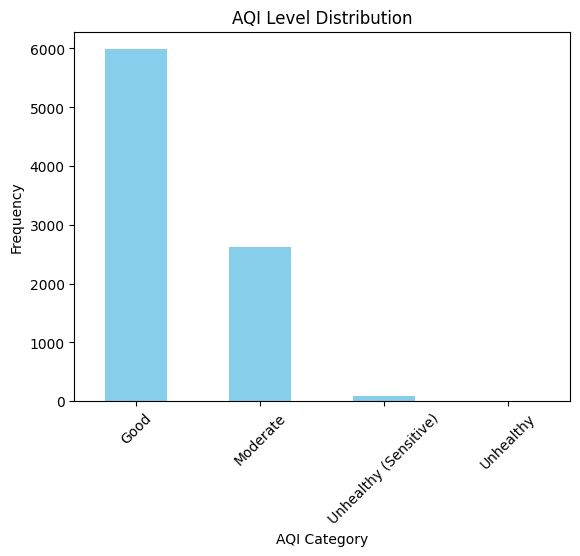

In [11]:
import matplotlib.pyplot as plt

# Bar chart of AQI levels
df['AQI_Level'].value_counts().plot(kind='bar', color='skyblue')
plt.title('AQI Level Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

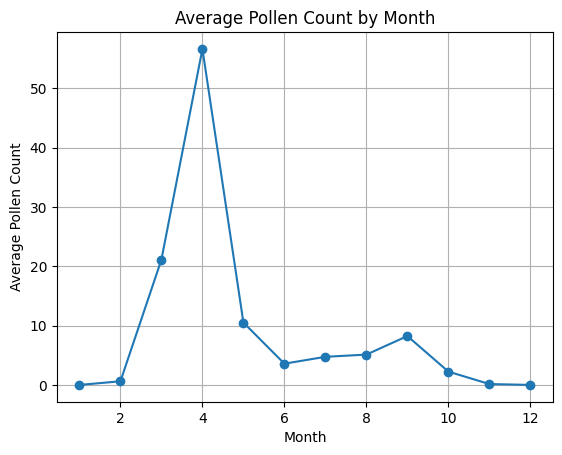

In [12]:
# Group by month and get average pollen level
monthly_avg = df.groupby('Month')['PollenCount'].mean()

monthly_avg.plot(kind='line', marker='o')
plt.title('Average Pollen Count by Month')
plt.xlabel('Month')
plt.ylabel('Average Pollen Count')
plt.grid(True)
plt.show()

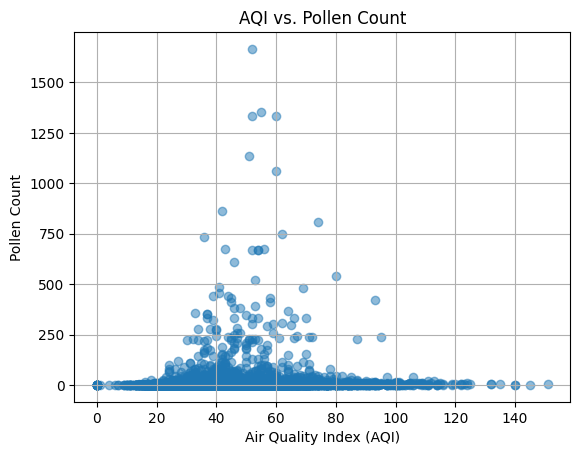

In [13]:
# Scatter plot to see correlation pattern
plt.scatter(df['AQI'], df['PollenCount'], alpha=0.5)
plt.title('AQI vs. Pollen Count')
plt.xlabel('Air Quality Index (AQI)')
plt.ylabel('Pollen Count')
plt.grid(True)
plt.show()

## Final Summary

This project analyzed the relationship between air quality and pollen count using time-based features and severity categorization.

- Data cleaned, enriched, and categorized
- Visual trends showed seasonal spikes in pollen
- AQI and pollen levels were often moderate but showed potential overlap
- Output is ready for reporting or use in public health awareness tools


In [14]:
df.to_csv('cleaned_air_quality_pollen.csv', index=False)

In [16]:
#from google.colab import files
#files.download('cleaned_air_quality_pollen.csv')